In [96]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [97]:
sequence_length = 4 # Length of the input sentence 'My name is Grant'
batch_size = 1      # Helps in parallel processing, for this we only need 1
input_dim = 512     # Vector dimension of every single word that goes into the attn unit
d_model = 512       # Vector dimension of the output of the attn unit for every single word
# Generating random data at this point using random normal distribution for our input
x = torch.randn( (batch_size, sequence_length, input_dim)) 
x.size()

torch.Size([1, 4, 512])

In [98]:
# Maps the input from the dimension of 512 to the model dimension (3 * 512) 
#   we do this because we have the query, key, and value vector
#   they are going to be concatenated
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [99]:
# 1 batch
# 4 words
# 1536 size of the vector
qkv = qkv_layer(x)
qkv.shape 

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

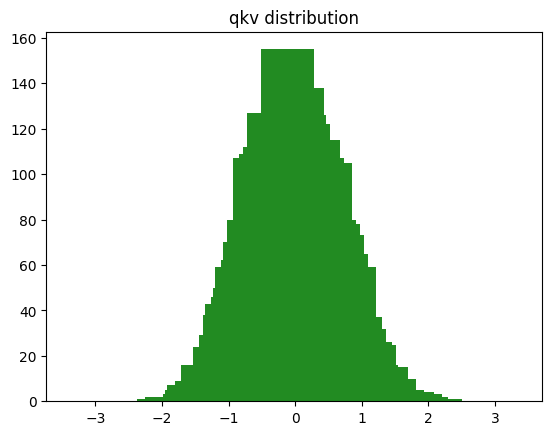

In [100]:
# Is a normal distribution because of the random.randn value selection
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1,1,0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [101]:
num_heads = 8                   # Number of attn heads
head_dim = d_model // num_heads # Dimensions of the heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [102]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [103]:
# Switches the number of heads and sequence length so that it is easier to perform operations?
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3 * head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [104]:
# 64 dimensions for each query, key, and value
# Breaks down the tensor by its last dimension (hence the -1 dimension)
q, k, v = qkv.chunk(3, dim = -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [105]:
d_k = q.size()[-1]  # Gets the size of the vector for k (should be 64)

# Scales the vector
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [106]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [107]:
# Creates the mask because we dont know the value of future inputs in the encoder
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal = 1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [108]:
# Adds the mask
(scaled + mask)[0][0]
scaled += mask

In [109]:
attention = F.softmax(scaled, dim = -1)

In [110]:
attention.shape

torch.Size([1, 8, 4, 4])

In [111]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5506, 0.4494, 0.0000, 0.0000],
        [0.4910, 0.2814, 0.2276, 0.0000],
        [0.1436, 0.3392, 0.2581, 0.2591]], grad_fn=<SelectBackward0>)

In [112]:
# New value vectors are going to be much more context aware
values = torch.matmul(attention, v)
values.shape # [batch_size, num_heads, sequence_size, 64dim vector]

torch.Size([1, 8, 4, 64])

In [113]:
# Combines everything that we just did into one function
#   mask is optional
def scaled_dot_product(q, k, v, mask = None):
    d_k = q.size()[1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim = -1)
    values = torch.matmul(attention, v)
    return values, attention

In [117]:
# Ranges aren't normalized
values, attention = scaled_dot_product(q, k, v, mask=None)
attention.shape
attention[0][0]

tensor([[0.1345, 0.0231, 0.1802, 0.6623],
        [0.4670, 0.2630, 0.0744, 0.1956],
        [0.4915, 0.1017, 0.0559, 0.3509],
        [0.0436, 0.4959, 0.2291, 0.2314]], grad_fn=<SelectBackward0>)

In [118]:
# Ranges are normalized
values, attention = scaled_dot_product(q, k, v, mask=mask)
attention.shape
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6397, 0.3603, 0.0000, 0.0000],
        [0.7572, 0.1567, 0.0861, 0.0000],
        [0.0436, 0.4959, 0.2291, 0.2314]], grad_fn=<SelectBackward0>)

In [119]:
values.size()

torch.Size([1, 8, 4, 64])

In [120]:
# Concat all of the 8 heads into a 512 dimension vector so that it is the same size as the input vector
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [121]:
linear_layer = nn.Linear(d_model, d_model)

In [122]:
out = linear_layer(values)

In [123]:
out.shape

torch.Size([1, 4, 512])

In [124]:
# Going to be a lot more context-aware than the input vector
out

tensor([[[-0.3486, -0.3819,  0.0263,  ..., -0.6428, -0.1368,  0.0860],
         [ 0.5068,  0.1764, -0.0333,  ..., -0.2347, -0.1577, -0.2736],
         [ 0.1781,  0.1412, -0.2231,  ..., -0.3044,  0.2722, -0.0822],
         [ 0.0851,  0.2373,  0.2015,  ...,  0.0092, -0.0511, -0.2182]]],
       grad_fn=<ViewBackward0>)

In [129]:
# This is the original input
x

tensor([[[ 1.8309, -0.8684,  1.2826,  ...,  2.2739,  0.1314,  1.6824],
         [ 0.8727,  0.0035, -0.3219,  ..., -0.1357,  0.2551,  0.0693],
         [-2.0006,  0.5296, -0.6376,  ..., -1.0491, -0.2748, -0.7955],
         [-0.8735, -0.1507,  0.8193,  ..., -0.6326,  0.9370,  1.2036]]])